## Build the model

In [ ]:
import os

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from utilities import load_data, draw, format_data
from error import error_func

## Build the model

In [1]:
sess = tf.InteractiveSession()
error_bound = 0.05
benchmark = 'bessel_Jnu'
learning_rate = 1e-4
e_func = error_func(benchmark)

inputs = tf.placeholder(tf.float32, shape=[None, 2], name='inputs')
label = tf.placeholder(tf.float32, shape=[None, 1], name='label')
clf_label = tf.placeholder(tf.float32, shape=[None, 1])

X0, Y0, X1, Y1 = load_data(benchmark)
train_data = np.hstack((X0, Y0))
test_data = np.hstack((X1, Y1))
np.random.shuffle(train_data)
np.random.shuffle(test_data)                                           
                                           
h1 = tf.layers.dense(inputs=inputs, units=4, activation=tf.nn.relu, kernel_initializer=tf.random_normal_initializer(0.0, 0.1))
cout = tf.layers.dense(inputs=h1, units=1, kernel_initializer=tf.random_normal_initializer(0.0, 0.1))
clf_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=clf_label, logits=cout,
                                                            name='clf_loss'))
clf_if_flag = tf.nn.sigmoid(cout)
h2 = tf.layers.dense(inputs=h1, units=4, activation=tf.nn.relu,
                                         kernel_initializer=tf.random_normal_initializer(0.0, 0.1))
aout = tf.layers.dense(inputs=h2, units=1,
                                         kernel_initializer=tf.random_normal_initializer(0.0, 0.1))
accuracy = e_func(label, aout)
loss = tf.losses.mean_squared_error(labels=label, predictions=aout)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss + clf_loss)
tf.global_variables_initializer().run()

def next_batch(batch_size=128, train=True):
    if train:
        batch = train_data[np.random.choice(list(range(len(train_data))), batch_size)]
    else:
        batch = test_data[np.random.choice(list(range(len(test_data))), batch_size)]
    x_data = batch[:, :-1]
    x_data = np.reshape(x_data, (batch_size, 2))
    y_data = batch[:, -1:]
    y_data = np.reshape(y_data, (batch_size, 1))
    return x_data, y_data
                   

def create_clf_data_label(sbatch_size=128, train=True, final=False):
    if not final:
        batch = next_batch(batch_size, train=train)
        accu = sess.run(accuracy, feed_dict={inputs: batch[0], label: batch[1]})
        if self.a_net[-1] != 1:
            re = np.all(accu < self.error_bound, 1).reshape([batch_size, 1])
        else:
            re = accu < self.error_bound
            
            
            
        return batch[0], batch[1], re
    else:
        batch = self.test_data
        x_data = batch[:, :-self.a_net[-1]]
        x_data = np.reshape(x_data, (self.test_data.shape[0], self.a_net[0]))
        y_data = batch[:, -self.a_net[-1]:]
        y_data = np.reshape(y_data, (self.test_data.shape[0], self.a_net[-1]))
        accu = self.sess.run(self.accuracy, feed_dict={self.inputs: x_data, self.label: y_data})
        if self.a_net[-1] != 1:
            re = np.all(accu < self.error_bound, 1).reshape([self.test_data.shape[0], 1])
        else:
            re = accu < self.error_bound
        return x_data, y_data, re

## Train the model

In [2]:
test_clf_loss = []
test_loss = []
test_err = []
test_true_invocation = []
test_clf_invocation = []
saver = tf.train.Saver()
for i in range(100000):
    if i % 100 == 0:
        x, y, clf_y = create_clf_data_label(train=False)
        l, cl, a, clf_if = sess.run([loss, clf_loss, accuracy, clf_if_flag],
                                         feed_dict={inputs: x, label: y, clf_label: clf_y})
        clf_if = clf_if > 0.5
        err = np.mean(a * clf_if)  # This is the error for those samples labeled Safe-to-Approximate
        true_invocation = np.sum(clf_y) / clf_y.size
        clf_invocation = np.sum(clf_if) / clf_if.size

        print(
            'Iter %04d, Loss: %.4f, ClfLoss: %.4f, AllLoss: %.5f, TrueIVC: %.3f, ClfIVC: %.3f, MRE: %f' % (
                i, l, cl, l + cl, true_invocation, clf_invocation, err))

        test_clf_loss.append(cl)
        test_loss.append(l)
        test_err.append(err)
        test_true_invocation.append(true_invocation)
        test_clf_invocation.append(clf_invocation)
    else:
        x, y, clf_y = create_clf_data_label(train=True)
        sess.run(train_op, feed_dict={inputs: x, label: y, clf_label: clf_y})

Iter 0000, Loss: 0.3181, ClfLoss: 0.6777, AllLoss: 0.99584, TrueIVC: 0.023, ClfIVC: 0.000, MRE: 0.000000
Iter 0100, Loss: 0.3214, ClfLoss: 0.6694, AllLoss: 0.99078, TrueIVC: 0.016, ClfIVC: 0.000, MRE: 0.000000
Iter 0200, Loss: 0.3452, ClfLoss: 0.6640, AllLoss: 1.00923, TrueIVC: 0.055, ClfIVC: 0.000, MRE: 0.000000
Iter 0300, Loss: 0.2961, ClfLoss: 0.6500, AllLoss: 0.94608, TrueIVC: 0.023, ClfIVC: 0.000, MRE: 0.000000
Iter 0400, Loss: 0.2703, ClfLoss: 0.6395, AllLoss: 0.90983, TrueIVC: 0.023, ClfIVC: 0.000, MRE: 0.000000
Iter 0500, Loss: 0.2540, ClfLoss: 0.6297, AllLoss: 0.88372, TrueIVC: 0.031, ClfIVC: 0.000, MRE: 0.000000
Iter 0600, Loss: 0.2768, ClfLoss: 0.6227, AllLoss: 0.89951, TrueIVC: 0.047, ClfIVC: 0.000, MRE: 0.000000
Iter 0700, Loss: 0.2231, ClfLoss: 0.6172, AllLoss: 0.84031, TrueIVC: 0.086, ClfIVC: 0.000, MRE: 0.000000
Iter 0800, Loss: 0.2223, ClfLoss: 0.6126, AllLoss: 0.83489, TrueIVC: 0.109, ClfIVC: 0.000, MRE: 0.000000
Iter 0900, Loss: 0.1969, ClfLoss: 0.5917, AllLoss: 0.78

Iter 7900, Loss: 0.0040, ClfLoss: 0.7021, AllLoss: 0.70615, TrueIVC: 0.562, ClfIVC: 0.000, MRE: 0.000000
Iter 8000, Loss: 0.0051, ClfLoss: 0.7078, AllLoss: 0.71297, TrueIVC: 0.633, ClfIVC: 0.000, MRE: 0.000000
Iter 8100, Loss: 0.0036, ClfLoss: 0.7062, AllLoss: 0.70978, TrueIVC: 0.656, ClfIVC: 0.000, MRE: 0.000000
Iter 8200, Loss: 0.0050, ClfLoss: 0.7009, AllLoss: 0.70591, TrueIVC: 0.609, ClfIVC: 0.000, MRE: 0.000000
Iter 8300, Loss: 0.0039, ClfLoss: 0.7017, AllLoss: 0.70558, TrueIVC: 0.672, ClfIVC: 0.000, MRE: 0.000000
Iter 8400, Loss: 0.0030, ClfLoss: 0.6996, AllLoss: 0.70263, TrueIVC: 0.703, ClfIVC: 0.000, MRE: 0.000000
Iter 8500, Loss: 0.0044, ClfLoss: 0.6951, AllLoss: 0.69951, TrueIVC: 0.664, ClfIVC: 0.000, MRE: 0.000000
Iter 8600, Loss: 0.0042, ClfLoss: 0.6933, AllLoss: 0.69743, TrueIVC: 0.578, ClfIVC: 0.453, MRE: 0.018518
Iter 8700, Loss: 0.0032, ClfLoss: 0.6909, AllLoss: 0.69410, TrueIVC: 0.641, ClfIVC: 0.945, MRE: 0.040241
Iter 8800, Loss: 0.0028, ClfLoss: 0.6871, AllLoss: 0.68

Iter 15700, Loss: 0.0020, ClfLoss: 0.5640, AllLoss: 0.56601, TrueIVC: 0.773, ClfIVC: 1.000, MRE: 0.036186
Iter 15800, Loss: 0.0034, ClfLoss: 0.5950, AllLoss: 0.59837, TrueIVC: 0.719, ClfIVC: 1.000, MRE: 0.041765
Iter 15900, Loss: 0.0032, ClfLoss: 0.6240, AllLoss: 0.62726, TrueIVC: 0.688, ClfIVC: 1.000, MRE: 0.044782
Iter 16000, Loss: 0.0042, ClfLoss: 0.6125, AllLoss: 0.61668, TrueIVC: 0.695, ClfIVC: 1.000, MRE: 0.046307
Iter 16100, Loss: 0.0041, ClfLoss: 0.6626, AllLoss: 0.66671, TrueIVC: 0.633, ClfIVC: 1.000, MRE: 0.047541
Iter 16200, Loss: 0.0044, ClfLoss: 0.6335, AllLoss: 0.63797, TrueIVC: 0.664, ClfIVC: 1.000, MRE: 0.047916
Iter 16300, Loss: 0.0029, ClfLoss: 0.5869, AllLoss: 0.58983, TrueIVC: 0.734, ClfIVC: 1.000, MRE: 0.040932
Iter 16400, Loss: 0.0034, ClfLoss: 0.5990, AllLoss: 0.60243, TrueIVC: 0.711, ClfIVC: 1.000, MRE: 0.045098
Iter 16500, Loss: 0.0036, ClfLoss: 0.5790, AllLoss: 0.58253, TrueIVC: 0.734, ClfIVC: 1.000, MRE: 0.042560
Iter 16600, Loss: 0.0053, ClfLoss: 0.5410, All

Iter 23500, Loss: 0.0023, ClfLoss: 0.4115, AllLoss: 0.41376, TrueIVC: 0.852, ClfIVC: 1.000, MRE: 0.033075
Iter 23600, Loss: 0.0025, ClfLoss: 0.4959, AllLoss: 0.49845, TrueIVC: 0.797, ClfIVC: 1.000, MRE: 0.034322
Iter 23700, Loss: 0.0015, ClfLoss: 0.3815, AllLoss: 0.38298, TrueIVC: 0.875, ClfIVC: 1.000, MRE: 0.028736
Iter 23800, Loss: 0.0018, ClfLoss: 0.4995, AllLoss: 0.50132, TrueIVC: 0.797, ClfIVC: 1.000, MRE: 0.031203
Iter 23900, Loss: 0.0015, ClfLoss: 0.4236, AllLoss: 0.42515, TrueIVC: 0.844, ClfIVC: 1.000, MRE: 0.029175
Iter 24000, Loss: 0.0012, ClfLoss: 0.3841, AllLoss: 0.38535, TrueIVC: 0.883, ClfIVC: 1.000, MRE: 0.026517
Iter 24100, Loss: 0.0020, ClfLoss: 0.6257, AllLoss: 0.62777, TrueIVC: 0.711, ClfIVC: 1.000, MRE: 0.035677
Iter 24200, Loss: 0.0016, ClfLoss: 0.4757, AllLoss: 0.47733, TrueIVC: 0.820, ClfIVC: 1.000, MRE: 0.030557
Iter 24300, Loss: 0.0024, ClfLoss: 0.4843, AllLoss: 0.48672, TrueIVC: 0.797, ClfIVC: 1.000, MRE: 0.036192
Iter 24400, Loss: 0.0020, ClfLoss: 0.4853, All

Iter 31300, Loss: 0.0037, ClfLoss: 0.5057, AllLoss: 0.50939, TrueIVC: 0.727, ClfIVC: 0.969, MRE: 0.037917
Iter 31400, Loss: 0.0029, ClfLoss: 0.5543, AllLoss: 0.55722, TrueIVC: 0.719, ClfIVC: 0.945, MRE: 0.037648
Iter 31500, Loss: 0.0031, ClfLoss: 0.5817, AllLoss: 0.58482, TrueIVC: 0.695, ClfIVC: 0.969, MRE: 0.039348
Iter 31600, Loss: 0.0034, ClfLoss: 0.5598, AllLoss: 0.56315, TrueIVC: 0.719, ClfIVC: 0.945, MRE: 0.033147
Iter 31700, Loss: 0.0021, ClfLoss: 0.5085, AllLoss: 0.51061, TrueIVC: 0.750, ClfIVC: 0.977, MRE: 0.033108
Iter 31800, Loss: 0.0051, ClfLoss: 0.4621, AllLoss: 0.46720, TrueIVC: 0.805, ClfIVC: 0.984, MRE: 0.029606
Iter 31900, Loss: 0.0034, ClfLoss: 0.5557, AllLoss: 0.55907, TrueIVC: 0.711, ClfIVC: 0.961, MRE: 0.034708
Iter 32000, Loss: 0.0025, ClfLoss: 0.5330, AllLoss: 0.53554, TrueIVC: 0.719, ClfIVC: 0.977, MRE: 0.034479
Iter 32100, Loss: 0.0033, ClfLoss: 0.4997, AllLoss: 0.50297, TrueIVC: 0.758, ClfIVC: 0.977, MRE: 0.032009
Iter 32200, Loss: 0.0024, ClfLoss: 0.5719, All

Iter 39100, Loss: 0.0016, ClfLoss: 0.3818, AllLoss: 0.38338, TrueIVC: 0.852, ClfIVC: 1.000, MRE: 0.029838
Iter 39200, Loss: 0.0008, ClfLoss: 0.2577, AllLoss: 0.25853, TrueIVC: 0.945, ClfIVC: 1.000, MRE: 0.022658
Iter 39300, Loss: 0.0018, ClfLoss: 0.4191, AllLoss: 0.42089, TrueIVC: 0.828, ClfIVC: 1.000, MRE: 0.029041
Iter 39400, Loss: 0.0016, ClfLoss: 0.3004, AllLoss: 0.30193, TrueIVC: 0.891, ClfIVC: 1.000, MRE: 0.027900
Iter 39500, Loss: 0.0018, ClfLoss: 0.3633, AllLoss: 0.36506, TrueIVC: 0.852, ClfIVC: 1.000, MRE: 0.029958
Iter 39600, Loss: 0.0017, ClfLoss: 0.2895, AllLoss: 0.29123, TrueIVC: 0.891, ClfIVC: 1.000, MRE: 0.030741
Iter 39700, Loss: 0.0023, ClfLoss: 0.3425, AllLoss: 0.34473, TrueIVC: 0.852, ClfIVC: 1.000, MRE: 0.031670
Iter 39800, Loss: 0.0012, ClfLoss: 0.3073, AllLoss: 0.30849, TrueIVC: 0.867, ClfIVC: 1.000, MRE: 0.024896
Iter 39900, Loss: 0.0015, ClfLoss: 0.3142, AllLoss: 0.31577, TrueIVC: 0.875, ClfIVC: 1.000, MRE: 0.027792
Iter 40000, Loss: 0.0014, ClfLoss: 0.4318, All

Iter 46900, Loss: 0.0017, ClfLoss: 0.1378, AllLoss: 0.13951, TrueIVC: 0.938, ClfIVC: 1.000, MRE: 0.024659
Iter 47000, Loss: 0.0011, ClfLoss: 0.1799, AllLoss: 0.18106, TrueIVC: 0.914, ClfIVC: 1.000, MRE: 0.023573
Iter 47100, Loss: 0.0013, ClfLoss: 0.1451, AllLoss: 0.14636, TrueIVC: 0.938, ClfIVC: 1.000, MRE: 0.024980
Iter 47200, Loss: 0.0015, ClfLoss: 0.1252, AllLoss: 0.12673, TrueIVC: 0.930, ClfIVC: 1.000, MRE: 0.023521
Iter 47300, Loss: 0.0019, ClfLoss: 0.1115, AllLoss: 0.11333, TrueIVC: 0.953, ClfIVC: 1.000, MRE: 0.024169
Iter 47400, Loss: 0.0011, ClfLoss: 0.2121, AllLoss: 0.21329, TrueIVC: 0.883, ClfIVC: 1.000, MRE: 0.023673
Iter 47500, Loss: 0.0017, ClfLoss: 0.1981, AllLoss: 0.19980, TrueIVC: 0.891, ClfIVC: 1.000, MRE: 0.025409
Iter 47600, Loss: 0.0012, ClfLoss: 0.2436, AllLoss: 0.24486, TrueIVC: 0.922, ClfIVC: 1.000, MRE: 0.024683
Iter 47700, Loss: 0.0016, ClfLoss: 0.1890, AllLoss: 0.19059, TrueIVC: 0.891, ClfIVC: 1.000, MRE: 0.027580
Iter 47800, Loss: 0.0011, ClfLoss: 0.1191, All

Iter 54700, Loss: 0.0012, ClfLoss: 0.1624, AllLoss: 0.16360, TrueIVC: 0.945, ClfIVC: 1.000, MRE: 0.022489
Iter 54800, Loss: 0.0020, ClfLoss: 0.1688, AllLoss: 0.17079, TrueIVC: 0.922, ClfIVC: 1.000, MRE: 0.024264
Iter 54900, Loss: 0.0011, ClfLoss: 0.1795, AllLoss: 0.18067, TrueIVC: 0.930, ClfIVC: 1.000, MRE: 0.023166
Iter 55000, Loss: 0.0011, ClfLoss: 0.1906, AllLoss: 0.19163, TrueIVC: 0.914, ClfIVC: 1.000, MRE: 0.022130
Iter 55100, Loss: 0.0007, ClfLoss: 0.1102, AllLoss: 0.11090, TrueIVC: 0.961, ClfIVC: 1.000, MRE: 0.018682
Iter 55200, Loss: 0.0012, ClfLoss: 0.1539, AllLoss: 0.15504, TrueIVC: 0.938, ClfIVC: 1.000, MRE: 0.022377
Iter 55300, Loss: 0.0006, ClfLoss: 0.1240, AllLoss: 0.12460, TrueIVC: 0.961, ClfIVC: 1.000, MRE: 0.018979
Iter 55400, Loss: 0.0005, ClfLoss: 0.1103, AllLoss: 0.11083, TrueIVC: 0.969, ClfIVC: 1.000, MRE: 0.016427
Iter 55500, Loss: 0.0007, ClfLoss: 0.2536, AllLoss: 0.25428, TrueIVC: 0.938, ClfIVC: 1.000, MRE: 0.020419
Iter 55600, Loss: 0.0009, ClfLoss: 0.1317, All

Iter 62500, Loss: 0.0006, ClfLoss: 0.1139, AllLoss: 0.11453, TrueIVC: 0.984, ClfIVC: 1.000, MRE: 0.019864
Iter 62600, Loss: 0.0007, ClfLoss: 0.1243, AllLoss: 0.12501, TrueIVC: 0.953, ClfIVC: 1.000, MRE: 0.019335
Iter 62700, Loss: 0.0010, ClfLoss: 0.1962, AllLoss: 0.19726, TrueIVC: 0.938, ClfIVC: 1.000, MRE: 0.022472
Iter 62800, Loss: 0.0012, ClfLoss: 0.2542, AllLoss: 0.25545, TrueIVC: 0.898, ClfIVC: 1.000, MRE: 0.024221
Iter 62900, Loss: 0.0009, ClfLoss: 0.1622, AllLoss: 0.16314, TrueIVC: 0.953, ClfIVC: 1.000, MRE: 0.022521
Iter 63000, Loss: 0.0009, ClfLoss: 0.2379, AllLoss: 0.23879, TrueIVC: 0.922, ClfIVC: 1.000, MRE: 0.021330
Iter 63100, Loss: 0.0009, ClfLoss: 0.2458, AllLoss: 0.24668, TrueIVC: 0.930, ClfIVC: 1.000, MRE: 0.022841
Iter 63200, Loss: 0.0009, ClfLoss: 0.1637, AllLoss: 0.16455, TrueIVC: 0.945, ClfIVC: 1.000, MRE: 0.021775
Iter 63300, Loss: 0.0006, ClfLoss: 0.1392, AllLoss: 0.13979, TrueIVC: 0.969, ClfIVC: 1.000, MRE: 0.019340
Iter 63400, Loss: 0.0009, ClfLoss: 0.2997, All

Iter 70300, Loss: 0.0010, ClfLoss: 0.2139, AllLoss: 0.21484, TrueIVC: 0.906, ClfIVC: 0.992, MRE: 0.021778
Iter 70400, Loss: 0.0007, ClfLoss: 0.2099, AllLoss: 0.21064, TrueIVC: 0.922, ClfIVC: 0.977, MRE: 0.018699
Iter 70500, Loss: 0.0007, ClfLoss: 0.1453, AllLoss: 0.14604, TrueIVC: 0.945, ClfIVC: 0.992, MRE: 0.019406
Iter 70600, Loss: 0.0007, ClfLoss: 0.2199, AllLoss: 0.22061, TrueIVC: 0.930, ClfIVC: 0.992, MRE: 0.018060
Iter 70700, Loss: 0.0009, ClfLoss: 0.2336, AllLoss: 0.23457, TrueIVC: 0.914, ClfIVC: 0.977, MRE: 0.019160
Iter 70800, Loss: 0.0009, ClfLoss: 0.2458, AllLoss: 0.24671, TrueIVC: 0.906, ClfIVC: 1.000, MRE: 0.022470
Iter 70900, Loss: 0.0010, ClfLoss: 0.2730, AllLoss: 0.27393, TrueIVC: 0.891, ClfIVC: 0.984, MRE: 0.022489
Iter 71000, Loss: 0.0009, ClfLoss: 0.2029, AllLoss: 0.20376, TrueIVC: 0.914, ClfIVC: 0.992, MRE: 0.021177
Iter 71100, Loss: 0.0013, ClfLoss: 0.2633, AllLoss: 0.26461, TrueIVC: 0.898, ClfIVC: 0.969, MRE: 0.021197
Iter 71200, Loss: 0.0010, ClfLoss: 0.2274, All

Iter 78100, Loss: 0.0010, ClfLoss: 0.1758, AllLoss: 0.17672, TrueIVC: 0.930, ClfIVC: 0.953, MRE: 0.018865
Iter 78200, Loss: 0.0011, ClfLoss: 0.2783, AllLoss: 0.27932, TrueIVC: 0.891, ClfIVC: 0.977, MRE: 0.022558
Iter 78300, Loss: 0.0008, ClfLoss: 0.2302, AllLoss: 0.23104, TrueIVC: 0.922, ClfIVC: 0.977, MRE: 0.021570
Iter 78400, Loss: 0.0015, ClfLoss: 0.2243, AllLoss: 0.22588, TrueIVC: 0.906, ClfIVC: 0.977, MRE: 0.020351
Iter 78500, Loss: 0.0010, ClfLoss: 0.2064, AllLoss: 0.20745, TrueIVC: 0.922, ClfIVC: 0.961, MRE: 0.020523
Iter 78600, Loss: 0.0012, ClfLoss: 0.2237, AllLoss: 0.22486, TrueIVC: 0.898, ClfIVC: 0.977, MRE: 0.020884
Iter 78700, Loss: 0.0011, ClfLoss: 0.2879, AllLoss: 0.28897, TrueIVC: 0.883, ClfIVC: 0.953, MRE: 0.022525
Iter 78800, Loss: 0.0010, ClfLoss: 0.2305, AllLoss: 0.23158, TrueIVC: 0.891, ClfIVC: 0.961, MRE: 0.020361
Iter 78900, Loss: 0.0011, ClfLoss: 0.3192, AllLoss: 0.32025, TrueIVC: 0.883, ClfIVC: 0.984, MRE: 0.023850
Iter 79000, Loss: 0.0010, ClfLoss: 0.2843, All

Iter 85900, Loss: 0.0011, ClfLoss: 0.4085, AllLoss: 0.40962, TrueIVC: 0.844, ClfIVC: 0.953, MRE: 0.023987
Iter 86000, Loss: 0.0009, ClfLoss: 0.2672, AllLoss: 0.26815, TrueIVC: 0.914, ClfIVC: 0.977, MRE: 0.021392
Iter 86100, Loss: 0.0009, ClfLoss: 0.3328, AllLoss: 0.33375, TrueIVC: 0.883, ClfIVC: 0.977, MRE: 0.021636
Iter 86200, Loss: 0.0013, ClfLoss: 0.3057, AllLoss: 0.30695, TrueIVC: 0.883, ClfIVC: 0.969, MRE: 0.023365
Iter 86300, Loss: 0.0010, ClfLoss: 0.2786, AllLoss: 0.27965, TrueIVC: 0.875, ClfIVC: 0.945, MRE: 0.020553
Iter 86400, Loss: 0.0012, ClfLoss: 0.3064, AllLoss: 0.30760, TrueIVC: 0.898, ClfIVC: 0.977, MRE: 0.022380
Iter 86500, Loss: 0.0014, ClfLoss: 0.3875, AllLoss: 0.38886, TrueIVC: 0.836, ClfIVC: 0.961, MRE: 0.024315
Iter 86600, Loss: 0.0012, ClfLoss: 0.3420, AllLoss: 0.34316, TrueIVC: 0.875, ClfIVC: 0.984, MRE: 0.025056
Iter 86700, Loss: 0.0008, ClfLoss: 0.2114, AllLoss: 0.21216, TrueIVC: 0.945, ClfIVC: 0.984, MRE: 0.019863
Iter 86800, Loss: 0.0012, ClfLoss: 0.4275, All

Iter 93700, Loss: 0.0009, ClfLoss: 0.2882, AllLoss: 0.28915, TrueIVC: 0.898, ClfIVC: 0.984, MRE: 0.022752
Iter 93800, Loss: 0.0007, ClfLoss: 0.2785, AllLoss: 0.27927, TrueIVC: 0.906, ClfIVC: 1.000, MRE: 0.021878
Iter 93900, Loss: 0.0010, ClfLoss: 0.2872, AllLoss: 0.28823, TrueIVC: 0.883, ClfIVC: 0.992, MRE: 0.025361
Iter 94000, Loss: 0.0012, ClfLoss: 0.3254, AllLoss: 0.32665, TrueIVC: 0.867, ClfIVC: 0.992, MRE: 0.025636
Iter 94100, Loss: 0.0012, ClfLoss: 0.2717, AllLoss: 0.27283, TrueIVC: 0.883, ClfIVC: 0.984, MRE: 0.023532
Iter 94200, Loss: 0.0007, ClfLoss: 0.2246, AllLoss: 0.22532, TrueIVC: 0.922, ClfIVC: 0.992, MRE: 0.020949
Iter 94300, Loss: 0.0008, ClfLoss: 0.2064, AllLoss: 0.20719, TrueIVC: 0.938, ClfIVC: 1.000, MRE: 0.022141
Iter 94400, Loss: 0.0008, ClfLoss: 0.1934, AllLoss: 0.19417, TrueIVC: 0.938, ClfIVC: 0.992, MRE: 0.021890
Iter 94500, Loss: 0.0010, ClfLoss: 0.2779, AllLoss: 0.27887, TrueIVC: 0.906, ClfIVC: 0.992, MRE: 0.023886
Iter 94600, Loss: 0.0007, ClfLoss: 0.2491, All

## Evaluate the model

In [4]:

re = []
ab = []
tr = []
ci = []
x, y, clf_y = create_clf_data_label(train=False, final=True)

clf_if, accu = sess.run([clf_if_flag, accuracy],
                             feed_dict={inputs: x, label: y})
clf_if = clf_if > 0.5
tr.append(np.sum(clf_y) / clf_y.size)
ci.append(np.sum(clf_if) / clf_if.size)
re.append(np.sum([1 if clf_y[i] == clf_if[i] else 0 for i in range(clf_if.size)]) / clf_if.size)
ab.append(np.sum(np.multiply(clf_if, np.mean(accu, 1, keepdims=True))))

print("Now we have tail!!" + '\n')
print("True invocation: \t\t\t\t" + str(np.mean(tr)) + '\n')
print("CLF invocation: \t\t\t\t" + str(np.mean(ci)) + '\n')
print("Final CLF accuracy: \t\t\t" + str(np.mean(re)) + '\n')
print("Error in CLF's prediction: \t\t" + str(np.mean(ab) / len(clf_if)) + '\n')


Now we have tail!!

True invocation: 				0.946266666667

CLF invocation: 				1.0

Final CLF accuracy: 			0.946266666667

Error in CLF's prediction: 		0.0199040405273



## Draw some auxiliary figures

Text(0.5,0.92,'Multi-Task method')

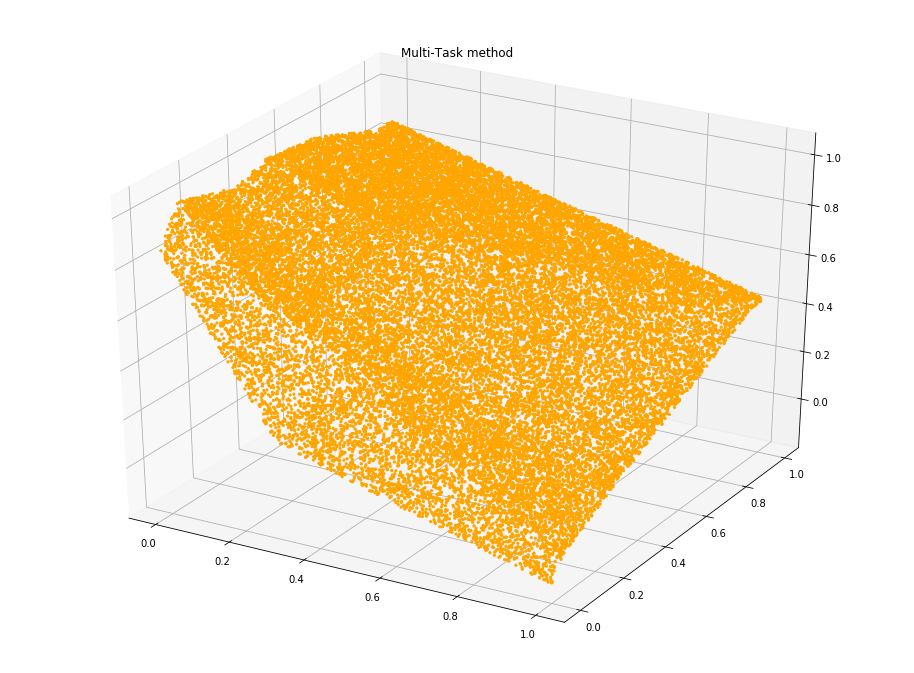

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

x, y, c = create_clf_data_label(train=False, final=True)
pred = sess.run(aout, feed_dict={inputs: x, label: y})
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x[:,0],x[:,1], y ,c='green',marker='.', alpha=0.1,label=u"C's output for 1st layer 1st neuron of A")

ax.scatter(x[:,0],x[:,1],pred,c='orange',marker='.', alpha=1.,label=u"C's output for 1st layer 2nd neuron of A")
# ax.set_xlabel('$X_0$')
# ax.set_ylabel('$X_1$')
# ax.set_zlabel("C's Output")
# ax.legend(loc=3)
ax.set_title("Multi-Task method")

Text(0.5,0.92,"C's ouput in Multi-Task")

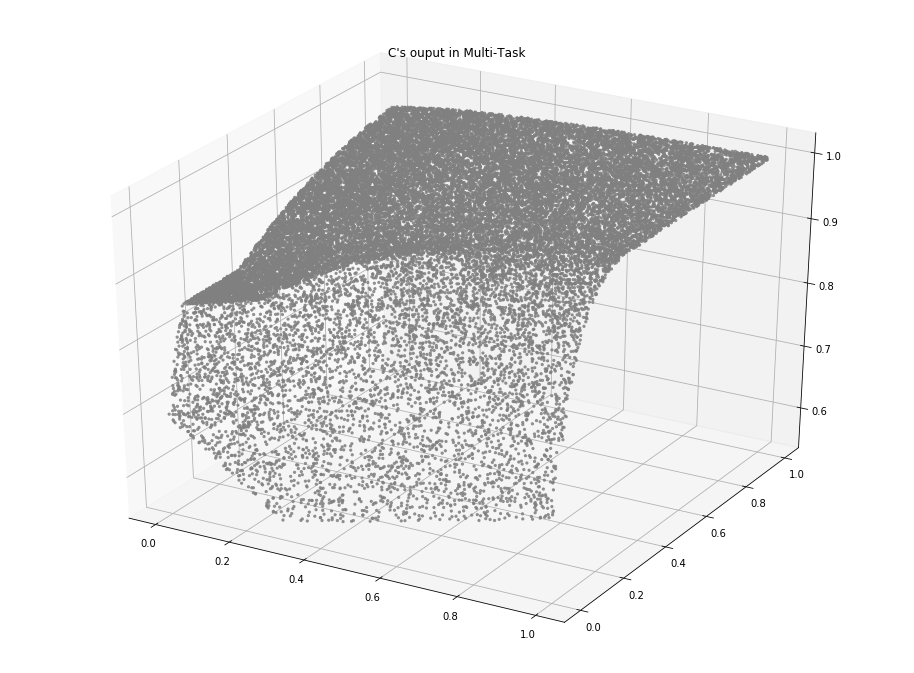

In [10]:
x, y, c = create_clf_data_label(train=False, final=True)
pred = sess.run(clf_if_flag, feed_dict={inputs: x, label: y})
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:,0],x[:,1],pred,c='grey',marker='.', alpha=0.8,label=u"C's output for 1st layer 2nd neuron of A")

ax.set_title("C's ouput in Multi-Task")